# Transfer Learning Experiment

In this notebook you will apply a pre-trained VGG 16 neural network to extract deep features from images of dogs, and experiment with transfer learning and fine-tuning to identify the dog breeds.

In [1]:
import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

### Loading the pre-trained VGG network

Keras provides many different pre-trained networks.  Here we load a VGG16 network pre-trained on ImageNet.

In [2]:
vgg = keras.applications.VGG16(include_top=True, weights='imagenet',input_shape=(224,224,3))

The model summary displays the sequence of layers in the model.

In [3]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

The deep features are the output of layer "fc2".  To get to these, we need to remove the last layer (the "predictions" layer).

In [4]:
vgg_features = keras.Model(inputs=vgg.input,outputs=vgg.layers[-2].output)

In [5]:
vgg_features.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Transfer learning on Oxford Pets

Now we will load the Oxford Pets dataset and set it up as a Tensorflow dataset.

In [6]:
import os
if not os.path.exists('oxford_pets.zip'):
  !wget "https://www.dropbox.com/s/pi0r047qbhfly7i/oxford_pets_corrected.zip?dl=1" -O oxford_pets.zip
  !unzip -q oxford_pets.zip

In [7]:
builder = tfds.folder_dataset.ImageFolder('oxford_pets')
train_ds = builder.as_dataset(split='train', shuffle_files=False)
test_ds = builder.as_dataset(split='test', shuffle_files=False)

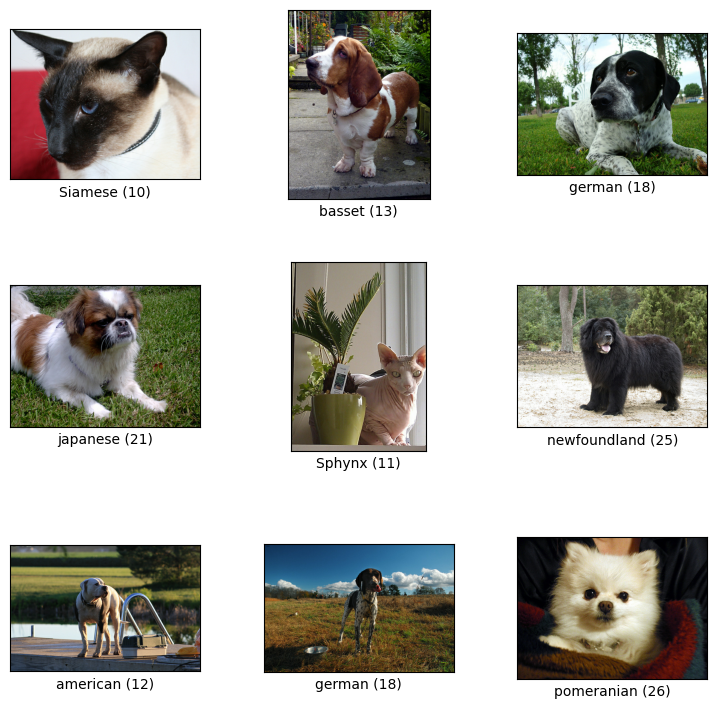

In [8]:
fig = tfds.show_examples(train_ds, builder.info)
fig.show()

We add some processing steps to the dataset:
* Resize images to 224x224
* Preprocess images using the VGG16 preprocess_input() function provided by Keras

In [9]:
train_ds = train_ds.map(lambda x: (x['image'],x['label']))                                # extract image and label into a tuple
train_ds = train_ds.map(lambda x,y: (tf.image.resize(x,[224,224]),y))                     # resize image to 224x224
train_ds = train_ds.map(lambda x,y: (keras.applications.vgg16.preprocess_input(x),y))     # apply VGG-16 preprocessing

Here we extract a validation split from the training data.

In [10]:
# shuffle the data
all_ds = train_ds.shuffle(1000)
# take first 10% as validation
val_ds = all_ds.take(len(all_ds)//10)
# take remaining 90% as training
train_ds = all_ds.skip(len(all_ds)//10)

In [11]:
train_ds = train_ds.batch(32)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [12]:
test_ds = test_ds.map(lambda x: (x['image'],x['label']))
test_ds = test_ds.map(lambda x,y: (tf.image.resize(x,[224,224]),y))
test_ds = test_ds.map(lambda x,y: (keras.applications.vgg16.preprocess_input(x),y))
test_ds = test_ds.batch(32)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

## Transfer learning with a MLP

In your first experiment, add a layer onto the VGG network to classify the dog images.  You can do this by creating a `Sequential` model with an input layer followed by `vgg_features` and then an appropriate layer for the classification task.  Note that there are 35 categories in the dataset.


In [13]:
from keras import Sequential
from keras.layers import Input, Dense

model = Sequential([
    Input(shape=(224, 224, 3)),
    vgg_features,
    Dense(35, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 4096)              134260544 
                                                                 
 dense (Dense)               (None, 35)                143395    
                                                                 
Total params: 134403939 (512.71 MB)
Trainable params: 134403939 (512.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In transfer learning the model, we only want to learn the last layer (the linear classifier); we don't want to update the VGG model weights.  A list of layers in the model is accessible at `model.layers`.  Set the `trainable` attribute of each layer (except the last one) to `False`.

In [14]:
for layer in model.layers[:-1]:
  layer.trainable = False

Now you are ready to compile the model and fit it to the training dataset.  You can call `.fit()` as follows:

`model.fit(train_ds, validation_data=val_ds, ...)`

In [15]:
from keras.optimizers import SGD

learning_rate = 0.2
batch_size = 32
epochs = 5

opt = SGD(learning_rate=learning_rate)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics='accuracy')

model.fit(train_ds,
          batch_size=batch_size,
          epochs=epochs)

Epoch 1/5
187/187 [==============================] - 50s 169ms/step - loss: 7.6785 - accuracy: 0.7580
Epoch 2/5
187/187 [==============================] - 38s 166ms/step - loss: 3.1650 - accuracy: 0.8752
Epoch 3/5
187/187 [==============================] - 37s 154ms/step - loss: 2.0557 - accuracy: 0.9118
Epoch 4/5
187/187 [==============================] - 36s 158ms/step - loss: 1.4521 - accuracy: 0.9280
Epoch 5/5
187/187 [==============================] - 36s 152ms/step - loss: 0.9915 - accuracy: 0.9481


## Fine-tuning the entire model

It is also possible to re-train the entire model, including the VGG backbone, starting from the pre-trained weights.  To prepare for this, re-create the model but don't set the `trainable` flag to `False` on any of the layers.  (Another option would be deactivate training on the convolutional layers but not the fully-connect layers.)

In [16]:
model = Sequential([
    Input(shape=(224, 224, 3)),
    vgg_features,
    Dense(35, activation='softmax')
])

learning_rate = 0.2
batch_size = 32
epochs = 5

opt = SGD(learning_rate=learning_rate)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics='accuracy')

model.fit(train_ds,
          batch_size=batch_size,
          epochs=epochs)

Epoch 1/5
187/187 [==============================] - 37s 155ms/step - loss: 6.8514 - accuracy: 0.7587
Epoch 2/5
187/187 [==============================] - 37s 156ms/step - loss: 2.9351 - accuracy: 0.8795
Epoch 3/5
187/187 [==============================] - 35s 149ms/step - loss: 1.8592 - accuracy: 0.9118
Epoch 4/5
187/187 [==============================] - 36s 157ms/step - loss: 1.2087 - accuracy: 0.9352
Epoch 5/5
187/187 [==============================] - 36s 154ms/step - loss: 0.9389 - accuracy: 0.9496


Usually in fine-tuning we want to use a low learning rate and a limited number of epochs, to avoid over-fitting.  Try to see if you can improve upon your transfer learning result using fine-tuning.

In [17]:
model = Sequential([
    Input(shape=(224, 224, 3)),
    vgg_features,
    Dense(35, activation='softmax')
])

learning_rate = 0.01
batch_size = 32
epochs = 3

opt = SGD(learning_rate=learning_rate)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics='accuracy')

model.fit(train_ds,
          batch_size=batch_size,
          epochs=epochs)

Epoch 1/3
187/187 [==============================] - 37s 153ms/step - loss: 0.7737 - accuracy: 0.7743
Epoch 2/3
187/187 [==============================] - 35s 158ms/step - loss: 0.3230 - accuracy: 0.8963
Epoch 3/3
187/187 [==============================] - 36s 156ms/step - loss: 0.2232 - accuracy: 0.9309


I lowered the learning rate and number of epochs, but was unable to improve upon my transfer learning result.